In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import pandas as pd
import os
from datasets import DatasetDict, Dataset
from transformers import AutoImageProcessor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import SwinForImageClassification, AutoImageProcessor  # Updated import
from transformers import DeiTFeatureExtractor, DeiTForImageClassification
from transformers import BeitForImageClassification, BeitImageProcessor

In [2]:
# Define the path to your dataset
data_dir = "C:/Users/Amir/Desktop/messier classification/gamma-correct"  # Replace with the path to your dataset

In [3]:
# Corrected imports
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from transformers import SwinForImageClassification, AutoImageProcessor

# DeiT-specific augmentations
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
])

# Initialize BEiT processor
model_name = "microsoft/beit-base-patch16-224"
feature_extractor = BeitImageProcessor.from_pretrained(model_name)

# Preprocessing function
def preprocess_image(image):
    augmented = augmentations(image)
    processed = feature_extractor(
        augmented,
        return_tensors="pt"
    )["pixel_values"][0]
    return processed
    return processed


# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=preprocess_image)
# Load datasets with ViT preprocessing
#train_dataset = datasets.ImageFolder(train_data_dir, transform=preprocess_image)
#test_dataset = datasets.ImageFolder(test_data_dir, transform=preprocess_image)

# Check the number of classes
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")  # Should be 21

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Number of classes: 7


C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [4]:
dataset.classes

['M1', 'M16', 'M17', 'M2', 'M27', 'M31', 'M8']

In [5]:

model = BeitForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
# Modify classifier head
model.classifier = nn.Sequential(
    nn.LayerNorm(model.config.hidden_size),
    nn.Dropout(0.5),
    nn.Linear(model.config.hidden_size, num_classes)
)

# Initialize weights
for module in model.classifier.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          

In [7]:
import torch
import torch.optim as optim
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torch.nn as nn
from transformers import SwinForImageClassification
from transformers import AutoFeatureExtractor

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.05)


# Define the optimizer with weight decay (L2 regularization)
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)







# Training loop settings
num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# CSV file for logging training metrics
csv_filename = "training_metrics.csv"
df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
df.to_csv(csv_filename, index=False)  # Initialize the CSV file

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        logits = outputs.logits  # Extract logits
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        train_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    # Compute epoch-level metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct, total = 0, 0

    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits
            loss = criterion(logits, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)

    # Compute epoch-level validation metrics
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Save metrics to CSV file
    df = pd.DataFrame([[epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy]],
                      columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
    df.to_csv(csv_filename, mode='a', header=False, index=False)


Epoch [1/100] Training: 100%|██████████| 70/70 [01:07<00:00,  1.03it/s, accuracy=73.3, loss=0.262]


Epoch [1/100], Train Loss: 0.7890, Train Accuracy: 73.35%


Epoch [1/100] Validation: 100%|██████████| 18/18 [00:07<00:00,  2.53it/s, accuracy=86.8, loss=0.352] 


Epoch [1/100], Val Loss: 0.3693, Val Accuracy: 86.79%


Epoch [2/100] Training: 100%|██████████| 70/70 [01:02<00:00,  1.11it/s, accuracy=88.6, loss=0.053] 


Epoch [2/100], Train Loss: 0.3474, Train Accuracy: 88.57%


Epoch [2/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.76it/s, accuracy=89.1, loss=0.171]


Epoch [2/100], Val Loss: 0.3853, Val Accuracy: 89.11%


Epoch [3/100] Training: 100%|██████████| 70/70 [01:02<00:00,  1.12it/s, accuracy=93.4, loss=0.28]  


Epoch [3/100], Train Loss: 0.2048, Train Accuracy: 93.39%


Epoch [3/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=91.8, loss=0.103] 


Epoch [3/100], Val Loss: 0.2618, Val Accuracy: 91.79%


Epoch [4/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=94.7, loss=0.107]  


Epoch [4/100], Train Loss: 0.1630, Train Accuracy: 94.73%


Epoch [4/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s, accuracy=90.4, loss=0.351]


Epoch [4/100], Val Loss: 0.3496, Val Accuracy: 90.36%


Epoch [5/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=96.2, loss=0.0095]  


Epoch [5/100], Train Loss: 0.1519, Train Accuracy: 96.21%


Epoch [5/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.69it/s, accuracy=92, loss=0.0449] 


Epoch [5/100], Val Loss: 0.2830, Val Accuracy: 91.96%


Epoch [6/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=96.8, loss=0.0195] 


Epoch [6/100], Train Loss: 0.0958, Train Accuracy: 96.79%


Epoch [6/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=92.7, loss=0.28] 


Epoch [6/100], Val Loss: 0.3006, Val Accuracy: 92.68%


Epoch [7/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=97.9, loss=0.000708]


Epoch [7/100], Train Loss: 0.0686, Train Accuracy: 97.90%


Epoch [7/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=92.5, loss=0.0457]


Epoch [7/100], Val Loss: 0.4170, Val Accuracy: 92.50%


Epoch [8/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.09it/s, accuracy=97.2, loss=0.0366]  


Epoch [8/100], Train Loss: 0.1030, Train Accuracy: 97.23%


Epoch [8/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s, accuracy=92.9, loss=0.252]   


Epoch [8/100], Val Loss: 0.2536, Val Accuracy: 92.86%


Epoch [9/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s, accuracy=92.2, loss=0.0231]  


Epoch [9/100], Train Loss: 0.2088, Train Accuracy: 92.19%


Epoch [9/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=91.1, loss=0.211]  


Epoch [9/100], Val Loss: 0.4307, Val Accuracy: 91.07%


Epoch [10/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s, accuracy=98.4, loss=0.179]   


Epoch [10/100], Train Loss: 0.0663, Train Accuracy: 98.39%


Epoch [10/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.68it/s, accuracy=94.1, loss=0.0394]  


Epoch [10/100], Val Loss: 0.2591, Val Accuracy: 94.11%


Epoch [11/100] Training: 100%|██████████| 70/70 [01:05<00:00,  1.08it/s, accuracy=98.7, loss=0.00042] 


Epoch [11/100], Train Loss: 0.0496, Train Accuracy: 98.71%


Epoch [11/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=92, loss=0.443]  


Epoch [11/100], Val Loss: 0.3507, Val Accuracy: 91.96%


Epoch [12/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s, accuracy=98.7, loss=0.13]    


Epoch [12/100], Train Loss: 0.0496, Train Accuracy: 98.66%


Epoch [12/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s, accuracy=92.3, loss=0.145]  


Epoch [12/100], Val Loss: 0.2932, Val Accuracy: 92.32%


Epoch [13/100] Training: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s, accuracy=98.2, loss=0.0363]  


Epoch [13/100], Train Loss: 0.0729, Train Accuracy: 98.21%


Epoch [13/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s, accuracy=93.2, loss=0.0943]  


Epoch [13/100], Val Loss: 0.3555, Val Accuracy: 93.21%


Epoch [14/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.08it/s, accuracy=98.9, loss=0.0197]  


Epoch [14/100], Train Loss: 0.0378, Train Accuracy: 98.88%


Epoch [14/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=90.9, loss=0.253] 


Epoch [14/100], Val Loss: 0.6457, Val Accuracy: 90.89%


Epoch [15/100] Training: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s, accuracy=99.3, loss=6.38e-5] 


Epoch [15/100], Train Loss: 0.0244, Train Accuracy: 99.29%


Epoch [15/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.60it/s, accuracy=93.9, loss=0.0707]


Epoch [15/100], Val Loss: 0.3236, Val Accuracy: 93.93%


Epoch [16/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.08it/s, accuracy=99.9, loss=0.000681]


Epoch [16/100], Train Loss: 0.0042, Train Accuracy: 99.91%


Epoch [16/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=94.5, loss=0.0529]


Epoch [16/100], Val Loss: 0.2786, Val Accuracy: 94.46%


Epoch [17/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.08it/s, accuracy=100, loss=3.6e-5]   


Epoch [17/100], Train Loss: 0.0019, Train Accuracy: 99.96%


Epoch [17/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.68it/s, accuracy=93.6, loss=0.345] 


Epoch [17/100], Val Loss: 0.2693, Val Accuracy: 93.57%


Epoch [18/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.08it/s, accuracy=99.7, loss=0.000308]


Epoch [18/100], Train Loss: 0.0090, Train Accuracy: 99.73%


Epoch [18/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=94.3, loss=0.0743]


Epoch [18/100], Val Loss: 0.2416, Val Accuracy: 94.29%


Epoch [19/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.08it/s, accuracy=100, loss=1.75e-5] 


Epoch [19/100], Train Loss: 0.0014, Train Accuracy: 99.96%


Epoch [19/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s, accuracy=94.8, loss=0.00167]


Epoch [19/100], Val Loss: 0.2474, Val Accuracy: 94.82%


Epoch [20/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.08it/s, accuracy=100, loss=3.22e-5]  


Epoch [20/100], Train Loss: 0.0022, Train Accuracy: 99.96%


Epoch [20/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.8, loss=0.42]   


Epoch [20/100], Val Loss: 0.2784, Val Accuracy: 94.82%


Epoch [21/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s, accuracy=100, loss=0.0109]  


Epoch [21/100], Train Loss: 0.0011, Train Accuracy: 100.00%


Epoch [21/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s, accuracy=94.6, loss=0.00045]


Epoch [21/100], Val Loss: 0.2705, Val Accuracy: 94.64%


Epoch [22/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.08it/s, accuracy=100, loss=0.12]    


Epoch [22/100], Train Loss: 0.0021, Train Accuracy: 99.96%


Epoch [22/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s, accuracy=94.5, loss=0.117] 


Epoch [22/100], Val Loss: 0.2153, Val Accuracy: 94.46%


Epoch [23/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s, accuracy=100, loss=6.28e-6] 


Epoch [23/100], Train Loss: 0.0009, Train Accuracy: 100.00%


Epoch [23/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.76it/s, accuracy=95.2, loss=0.0859]


Epoch [23/100], Val Loss: 0.1772, Val Accuracy: 95.18%


Epoch [24/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=0.000129]


Epoch [24/100], Train Loss: 0.0005, Train Accuracy: 100.00%


Epoch [24/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.63it/s, accuracy=95.9, loss=0.000892]


Epoch [24/100], Val Loss: 0.1966, Val Accuracy: 95.89%


Epoch [25/100] Training: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s, accuracy=100, loss=3.61e-6] 


Epoch [25/100], Train Loss: 0.0005, Train Accuracy: 100.00%


Epoch [25/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.65it/s, accuracy=95.9, loss=0.273]   


Epoch [25/100], Val Loss: 0.2068, Val Accuracy: 95.89%


Epoch [26/100] Training: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s, accuracy=99.9, loss=1.12e-5] 


Epoch [26/100], Train Loss: 0.0015, Train Accuracy: 99.91%


Epoch [26/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s, accuracy=94.5, loss=0.00374]


Epoch [26/100], Val Loss: 0.1976, Val Accuracy: 94.46%


Epoch [27/100] Training: 100%|██████████| 70/70 [01:05<00:00,  1.06it/s, accuracy=100, loss=0.000157] 


Epoch [27/100], Train Loss: 0.0009, Train Accuracy: 99.96%


Epoch [27/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.66it/s, accuracy=95.5, loss=0.248] 


Epoch [27/100], Val Loss: 0.2289, Val Accuracy: 95.54%


Epoch [28/100] Training: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s, accuracy=100, loss=1.29e-5]  


Epoch [28/100], Train Loss: 0.0008, Train Accuracy: 99.96%


Epoch [28/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.76it/s, accuracy=94.1, loss=0.202] 


Epoch [28/100], Val Loss: 0.2374, Val Accuracy: 94.11%


Epoch [29/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=99.9, loss=1.08e-5] 


Epoch [29/100], Train Loss: 0.0012, Train Accuracy: 99.91%


Epoch [29/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95, loss=0.00029]  


Epoch [29/100], Val Loss: 0.2321, Val Accuracy: 95.00%


Epoch [30/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=3.04e-5]  


Epoch [30/100], Train Loss: 0.0015, Train Accuracy: 99.96%


Epoch [30/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s, accuracy=95, loss=0.395]    


Epoch [30/100], Val Loss: 0.2802, Val Accuracy: 95.00%


Epoch [31/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=5.15e-5] 


Epoch [31/100], Train Loss: 0.0008, Train Accuracy: 100.00%


Epoch [31/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.6, loss=0.0579]


Epoch [31/100], Val Loss: 0.2645, Val Accuracy: 94.64%


Epoch [32/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=99.9, loss=3.03e-6] 


Epoch [32/100], Train Loss: 0.0025, Train Accuracy: 99.91%


Epoch [32/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s, accuracy=94.6, loss=0.0149]  


Epoch [32/100], Val Loss: 0.2421, Val Accuracy: 94.64%


Epoch [33/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=1.04e-5] 


Epoch [33/100], Train Loss: 0.0005, Train Accuracy: 100.00%


Epoch [33/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=95.7, loss=0.047] 


Epoch [33/100], Val Loss: 0.2075, Val Accuracy: 95.71%


Epoch [34/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=99.9, loss=1.26e-5] 


Epoch [34/100], Train Loss: 0.0014, Train Accuracy: 99.91%


Epoch [34/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=94.8, loss=0.00754] 


Epoch [34/100], Val Loss: 0.2384, Val Accuracy: 94.82%


Epoch [35/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=0.000348] 


Epoch [35/100], Train Loss: 0.0017, Train Accuracy: 99.96%


Epoch [35/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=94.6, loss=0.256] 


Epoch [35/100], Val Loss: 0.2462, Val Accuracy: 94.64%


Epoch [36/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=4.92e-6] 


Epoch [36/100], Train Loss: 0.0004, Train Accuracy: 100.00%


Epoch [36/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=94.6, loss=0.134]  


Epoch [36/100], Val Loss: 0.2657, Val Accuracy: 94.64%


Epoch [37/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=1.86e-5] 


Epoch [37/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [37/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=95.5, loss=0.103] 


Epoch [37/100], Val Loss: 0.2204, Val Accuracy: 95.54%


Epoch [38/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=1.32e-5] 


Epoch [38/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [38/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95.2, loss=0.0116] 


Epoch [38/100], Val Loss: 0.2435, Val Accuracy: 95.18%


Epoch [39/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=0.000233]


Epoch [39/100], Train Loss: 0.0004, Train Accuracy: 100.00%


Epoch [39/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s, accuracy=94.8, loss=0.00572] 


Epoch [39/100], Val Loss: 0.2429, Val Accuracy: 94.82%


Epoch [40/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=4.94e-6] 


Epoch [40/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [40/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=94.5, loss=0.00695]


Epoch [40/100], Val Loss: 0.2639, Val Accuracy: 94.46%


Epoch [41/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=99.9, loss=6.68e-5] 


Epoch [41/100], Train Loss: 0.0018, Train Accuracy: 99.91%


Epoch [41/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.6, loss=0.0123] 


Epoch [41/100], Val Loss: 0.2476, Val Accuracy: 94.64%


Epoch [42/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=1.86e-5] 


Epoch [42/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [42/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=96.2, loss=0.0117] 


Epoch [42/100], Val Loss: 0.2156, Val Accuracy: 96.25%


Epoch [43/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.00238] 


Epoch [43/100], Train Loss: 0.0007, Train Accuracy: 99.96%


Epoch [43/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95.5, loss=0.000561]


Epoch [43/100], Val Loss: 0.2426, Val Accuracy: 95.54%


Epoch [44/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=7.79e-5] 


Epoch [44/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [44/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=94.6, loss=0.00165]


Epoch [44/100], Val Loss: 0.2109, Val Accuracy: 94.64%


Epoch [45/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=7.87e-6] 


Epoch [45/100], Train Loss: 0.0004, Train Accuracy: 100.00%


Epoch [45/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=94.1, loss=0.00743]


Epoch [45/100], Val Loss: 0.2471, Val Accuracy: 94.11%


Epoch [46/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=1.29e-5] 


Epoch [46/100], Train Loss: 0.0004, Train Accuracy: 100.00%


Epoch [46/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=95, loss=0.0229]  


Epoch [46/100], Val Loss: 0.2172, Val Accuracy: 95.00%


Epoch [47/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=1.42e-5] 


Epoch [47/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [47/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.6, loss=0.0259]


Epoch [47/100], Val Loss: 0.2227, Val Accuracy: 94.64%


Epoch [48/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.000168]


Epoch [48/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [48/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=94.8, loss=0.183]  


Epoch [48/100], Val Loss: 0.2583, Val Accuracy: 94.82%


Epoch [49/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=4.4e-6]   


Epoch [49/100], Train Loss: 0.0049, Train Accuracy: 99.96%


Epoch [49/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=94.3, loss=0.00828]


Epoch [49/100], Val Loss: 0.2552, Val Accuracy: 94.29%


Epoch [50/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=6.49e-5] 


Epoch [50/100], Train Loss: 0.0005, Train Accuracy: 100.00%


Epoch [50/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.76it/s, accuracy=95, loss=0.00131] 


Epoch [50/100], Val Loss: 0.2454, Val Accuracy: 95.00%


Epoch [51/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=99.9, loss=3.71e-5] 


Epoch [51/100], Train Loss: 0.0026, Train Accuracy: 99.91%


Epoch [51/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=95.2, loss=0.154]   


Epoch [51/100], Val Loss: 0.2434, Val Accuracy: 95.18%


Epoch [52/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.000126]


Epoch [52/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [52/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=95, loss=0.000991]


Epoch [52/100], Val Loss: 0.2208, Val Accuracy: 95.00%


Epoch [53/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=1.95e-6] 


Epoch [53/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [53/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.6, loss=0.0568] 


Epoch [53/100], Val Loss: 0.2330, Val Accuracy: 94.64%


Epoch [54/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=8.32e-5]  


Epoch [54/100], Train Loss: 0.0010, Train Accuracy: 99.96%


Epoch [54/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.8, loss=0.0527]


Epoch [54/100], Val Loss: 0.2235, Val Accuracy: 94.82%


Epoch [55/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=4.06e-6]  


Epoch [55/100], Train Loss: 0.0010, Train Accuracy: 99.96%


Epoch [55/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95, loss=0.0855]   


Epoch [55/100], Val Loss: 0.2439, Val Accuracy: 95.00%


Epoch [56/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=0.000123] 


Epoch [56/100], Train Loss: 0.0021, Train Accuracy: 99.96%


Epoch [56/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s, accuracy=95.2, loss=0.0973] 


Epoch [56/100], Val Loss: 0.2489, Val Accuracy: 95.18%


Epoch [57/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=0.00033] 


Epoch [57/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [57/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.6, loss=0.00186] 


Epoch [57/100], Val Loss: 0.2200, Val Accuracy: 94.64%


Epoch [58/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=1.14e-5] 


Epoch [58/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [58/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=94.6, loss=0.0029]


Epoch [58/100], Val Loss: 0.2512, Val Accuracy: 94.64%


Epoch [59/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=9.02e-7]  


Epoch [59/100], Train Loss: 0.0005, Train Accuracy: 99.96%


Epoch [59/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95.2, loss=0.0148]


Epoch [59/100], Val Loss: 0.1724, Val Accuracy: 95.18%


Epoch [60/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=6.91e-6] 


Epoch [60/100], Train Loss: 0.0003, Train Accuracy: 100.00%


Epoch [60/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=95.5, loss=0.14]   


Epoch [60/100], Val Loss: 0.2159, Val Accuracy: 95.54%


Epoch [61/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=3.37e-5]  


Epoch [61/100], Train Loss: 0.0011, Train Accuracy: 99.96%


Epoch [61/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95.5, loss=0.0371]


Epoch [61/100], Val Loss: 0.1915, Val Accuracy: 95.54%


Epoch [62/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=99.9, loss=0.000197]


Epoch [62/100], Train Loss: 0.0027, Train Accuracy: 99.91%


Epoch [62/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.76it/s, accuracy=95, loss=0.0275]  


Epoch [62/100], Val Loss: 0.2478, Val Accuracy: 95.00%


Epoch [63/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.0223]  


Epoch [63/100], Train Loss: 0.0004, Train Accuracy: 99.96%


Epoch [63/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=94.8, loss=0.00127]


Epoch [63/100], Val Loss: 0.2363, Val Accuracy: 94.82%


Epoch [64/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=8.66e-6]  


Epoch [64/100], Train Loss: 0.0005, Train Accuracy: 99.96%


Epoch [64/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.76it/s, accuracy=95.5, loss=0.000239]


Epoch [64/100], Val Loss: 0.1972, Val Accuracy: 95.54%


Epoch [65/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=9.57e-6] 


Epoch [65/100], Train Loss: 0.0007, Train Accuracy: 99.96%


Epoch [65/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.8, loss=0.172] 


Epoch [65/100], Val Loss: 0.2740, Val Accuracy: 94.82%


Epoch [66/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=6.25e-5] 


Epoch [66/100], Train Loss: 0.0032, Train Accuracy: 99.96%


Epoch [66/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.8, loss=0.00894]


Epoch [66/100], Val Loss: 0.2458, Val Accuracy: 94.82%


Epoch [67/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=99.9, loss=5.51e-5] 


Epoch [67/100], Train Loss: 0.0017, Train Accuracy: 99.91%


Epoch [67/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=94.8, loss=0.00724]


Epoch [67/100], Val Loss: 0.2427, Val Accuracy: 94.82%


Epoch [68/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.000485]


Epoch [68/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [68/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=95.4, loss=0.0022] 


Epoch [68/100], Val Loss: 0.2158, Val Accuracy: 95.36%


Epoch [69/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=99.9, loss=2.07e-5] 


Epoch [69/100], Train Loss: 0.0041, Train Accuracy: 99.87%


Epoch [69/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95, loss=0.0152]    


Epoch [69/100], Val Loss: 0.2393, Val Accuracy: 95.00%


Epoch [70/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=3.19e-5] 


Epoch [70/100], Train Loss: 0.0008, Train Accuracy: 100.00%


Epoch [70/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=95, loss=0.00118]  


Epoch [70/100], Val Loss: 0.2131, Val Accuracy: 95.00%


Epoch [71/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=4.69e-6] 


Epoch [71/100], Train Loss: 0.0003, Train Accuracy: 100.00%


Epoch [71/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s, accuracy=95.4, loss=0.0486] 


Epoch [71/100], Val Loss: 0.2517, Val Accuracy: 95.36%


Epoch [72/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=4.22e-5]  


Epoch [72/100], Train Loss: 0.0045, Train Accuracy: 99.96%


Epoch [72/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=94.6, loss=0.0379]


Epoch [72/100], Val Loss: 0.2451, Val Accuracy: 94.64%


Epoch [73/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.000208] 


Epoch [73/100], Train Loss: 0.0015, Train Accuracy: 99.96%


Epoch [73/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=95.5, loss=0.0296] 


Epoch [73/100], Val Loss: 0.2520, Val Accuracy: 95.54%


Epoch [74/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=1.73e-5] 


Epoch [74/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [74/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=95.5, loss=0.00338]


Epoch [74/100], Val Loss: 0.2055, Val Accuracy: 95.54%


Epoch [75/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=3.92e-5] 


Epoch [75/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [75/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=95, loss=0.000349]  


Epoch [75/100], Val Loss: 0.2227, Val Accuracy: 95.00%


Epoch [76/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.000377]


Epoch [76/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [76/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=94.8, loss=0.00272]


Epoch [76/100], Val Loss: 0.2232, Val Accuracy: 94.82%


Epoch [77/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=1.1e-5]  


Epoch [77/100], Train Loss: 0.0003, Train Accuracy: 100.00%


Epoch [77/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95.4, loss=0.003]  


Epoch [77/100], Val Loss: 0.2067, Val Accuracy: 95.36%


Epoch [78/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=99.9, loss=6.31e-6] 


Epoch [78/100], Train Loss: 0.0018, Train Accuracy: 99.91%


Epoch [78/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=95.7, loss=0.0338]


Epoch [78/100], Val Loss: 0.2025, Val Accuracy: 95.71%


Epoch [79/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.000642]


Epoch [79/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [79/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=94.8, loss=0.0299]


Epoch [79/100], Val Loss: 0.2128, Val Accuracy: 94.82%


Epoch [80/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=1.47e-6]  


Epoch [80/100], Train Loss: 0.0008, Train Accuracy: 99.96%


Epoch [80/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s, accuracy=95, loss=0.00053] 


Epoch [80/100], Val Loss: 0.2315, Val Accuracy: 95.00%


Epoch [81/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=3.44e-5]  


Epoch [81/100], Train Loss: 0.0019, Train Accuracy: 99.96%


Epoch [81/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=95, loss=0.00258]   


Epoch [81/100], Val Loss: 0.2196, Val Accuracy: 95.00%


Epoch [82/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=99.8, loss=3.54e-5] 


Epoch [82/100], Train Loss: 0.0038, Train Accuracy: 99.82%


Epoch [82/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.6, loss=0.00775]


Epoch [82/100], Val Loss: 0.2168, Val Accuracy: 94.64%


Epoch [83/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=3.87e-6]  


Epoch [83/100], Train Loss: 0.0011, Train Accuracy: 99.96%


Epoch [83/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=95.7, loss=0.000541]


Epoch [83/100], Val Loss: 0.2334, Val Accuracy: 95.71%


Epoch [84/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=8.2e-7]  


Epoch [84/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [84/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=94.6, loss=0.0212]


Epoch [84/100], Val Loss: 0.2370, Val Accuracy: 94.64%


Epoch [85/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=6.38e-5] 


Epoch [85/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [85/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=94.1, loss=0.0481]


Epoch [85/100], Val Loss: 0.2677, Val Accuracy: 94.11%


Epoch [86/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=1.87e-6] 


Epoch [86/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [86/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95, loss=0.0169]   


Epoch [86/100], Val Loss: 0.2182, Val Accuracy: 95.00%


Epoch [87/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=3.58e-5]  


Epoch [87/100], Train Loss: 0.0022, Train Accuracy: 99.96%


Epoch [87/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s, accuracy=94.6, loss=0.00365]


Epoch [87/100], Val Loss: 0.2206, Val Accuracy: 94.64%


Epoch [88/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.000127]


Epoch [88/100], Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch [88/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95.5, loss=0.003]  


Epoch [88/100], Val Loss: 0.2123, Val Accuracy: 95.54%


Epoch [89/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=0.000192]


Epoch [89/100], Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch [89/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95, loss=0.236]    


Epoch [89/100], Val Loss: 0.2410, Val Accuracy: 95.00%


Epoch [90/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=2e-5]    


Epoch [90/100], Train Loss: 0.0003, Train Accuracy: 100.00%


Epoch [90/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=95.7, loss=0.134]  


Epoch [90/100], Val Loss: 0.1793, Val Accuracy: 95.71%


Epoch [91/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=99.9, loss=4.63e-6] 


Epoch [91/100], Train Loss: 0.0015, Train Accuracy: 99.91%


Epoch [91/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=95.2, loss=0.00142]


Epoch [91/100], Val Loss: 0.2180, Val Accuracy: 95.18%


Epoch [92/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=1.28e-5] 


Epoch [92/100], Train Loss: 0.0003, Train Accuracy: 100.00%


Epoch [92/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=95.5, loss=0.0333] 


Epoch [92/100], Val Loss: 0.1788, Val Accuracy: 95.54%


Epoch [93/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=0.0217]  


Epoch [93/100], Train Loss: 0.0005, Train Accuracy: 100.00%


Epoch [93/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=94.3, loss=0.0497]


Epoch [93/100], Val Loss: 0.2413, Val Accuracy: 94.29%


Epoch [94/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=6.7e-6]  


Epoch [94/100], Train Loss: 0.0003, Train Accuracy: 100.00%


Epoch [94/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=95, loss=0.00371]  


Epoch [94/100], Val Loss: 0.2208, Val Accuracy: 95.00%


Epoch [95/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=4.37e-5] 


Epoch [95/100], Train Loss: 0.0003, Train Accuracy: 100.00%


Epoch [95/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95.2, loss=0.0112] 


Epoch [95/100], Val Loss: 0.2150, Val Accuracy: 95.18%


Epoch [96/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=5.45e-6]  


Epoch [96/100], Train Loss: 0.0006, Train Accuracy: 99.96%


Epoch [96/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s, accuracy=95.4, loss=0.00175] 


Epoch [96/100], Val Loss: 0.2947, Val Accuracy: 95.36%


Epoch [97/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=4.71e-5] 


Epoch [97/100], Train Loss: 0.0008, Train Accuracy: 99.96%


Epoch [97/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s, accuracy=94.6, loss=0.00435]


Epoch [97/100], Val Loss: 0.2402, Val Accuracy: 94.64%


Epoch [98/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s, accuracy=100, loss=5.76e-6] 


Epoch [98/100], Train Loss: 0.0008, Train Accuracy: 100.00%


Epoch [98/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=95.2, loss=0.000223]


Epoch [98/100], Val Loss: 0.2311, Val Accuracy: 95.18%


Epoch [99/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=0.000119]


Epoch [99/100], Train Loss: 0.0003, Train Accuracy: 100.00%


Epoch [99/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, accuracy=95.7, loss=0.0258]


Epoch [99/100], Val Loss: 0.1932, Val Accuracy: 95.71%


Epoch [100/100] Training: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s, accuracy=100, loss=6.79e-6]  


Epoch [100/100], Train Loss: 0.0004, Train Accuracy: 99.96%


Epoch [100/100] Validation: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s, accuracy=95, loss=0.0552]   

Epoch [100/100], Val Loss: 0.2609, Val Accuracy: 95.00%


In [8]:
# Save the model's state dictionary
torch.save(model.state_dict(), "messier-BeitViT.pth")

print("Model saved successfully!")

Model saved successfully!


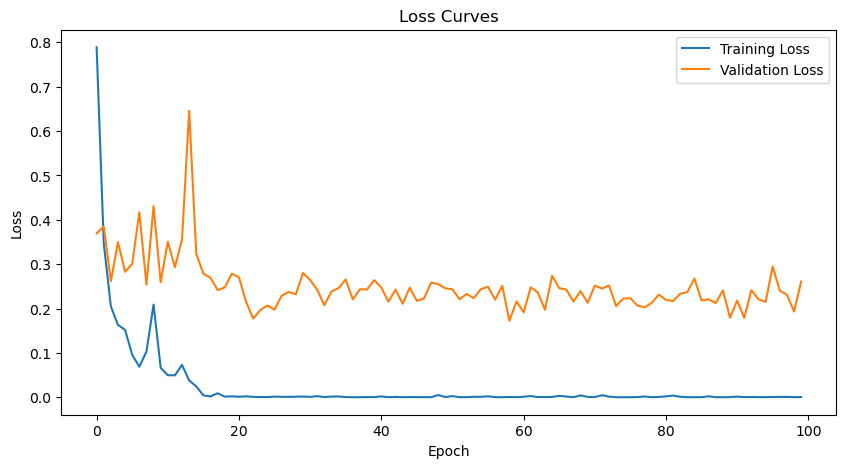

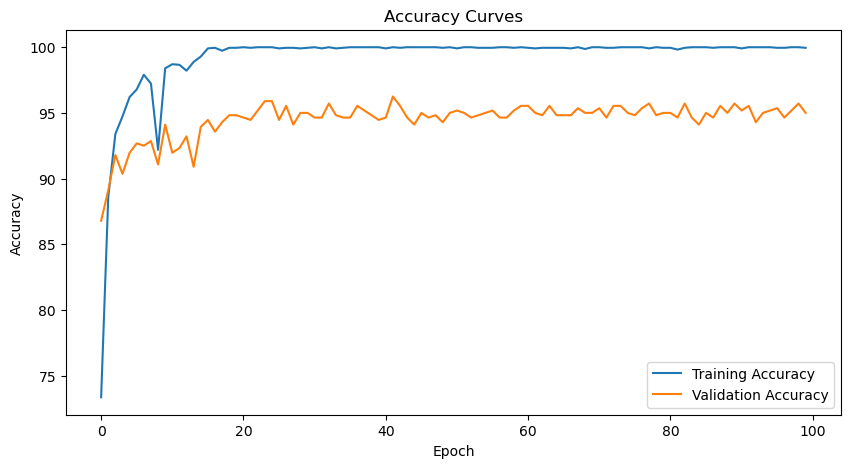

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [10]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Disable gradient computation for testing
with torch.no_grad():
    # Wrap test_loader with tqdm for a progress bar
    test_loop = tqdm(val_loader, desc="Testing SwinViT", ncols=100)
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Vision Transformer model
        outputs = model(images)  # This will return an object, not just the logits
        
        # Access the logits from the model's output object
        logits = outputs.logits  

        # Compute loss
        loss = criterion(logits, labels)

        # Accumulate loss
        test_loss += loss.item() * images.size(0)  # Scale loss by batch size

        # Compute accuracy
        _, predicted = torch.max(logits.detach(), 1)  # Use .detach() instead of .data
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar with loss and accuracy
        test_loop.set_postfix(loss=test_loss / total, accuracy=(correct / total) * 100)

# Compute final test loss and accuracy
test_loss /= total  # Normalize loss properly
test_accuracy = 100 * correct / total

# Print the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Testing SwinViT: 100%|█████████████████████| 18/18 [00:06<00:00,  2.69it/s, accuracy=95, loss=0.216]

Test Loss: 0.2163, Test Accuracy: 95.00%


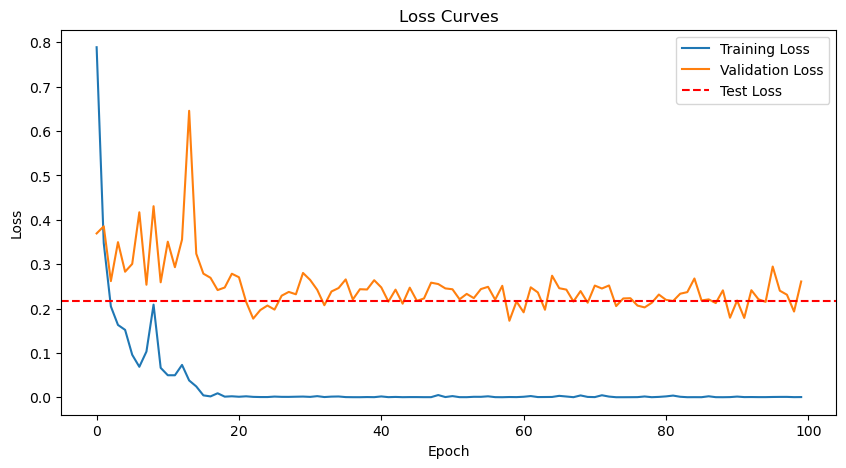

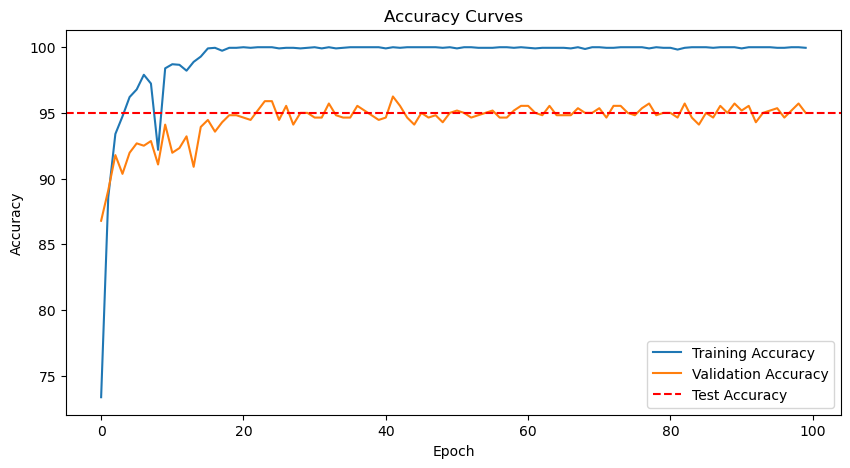

In [11]:
import matplotlib.pyplot as plt

# Plot training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

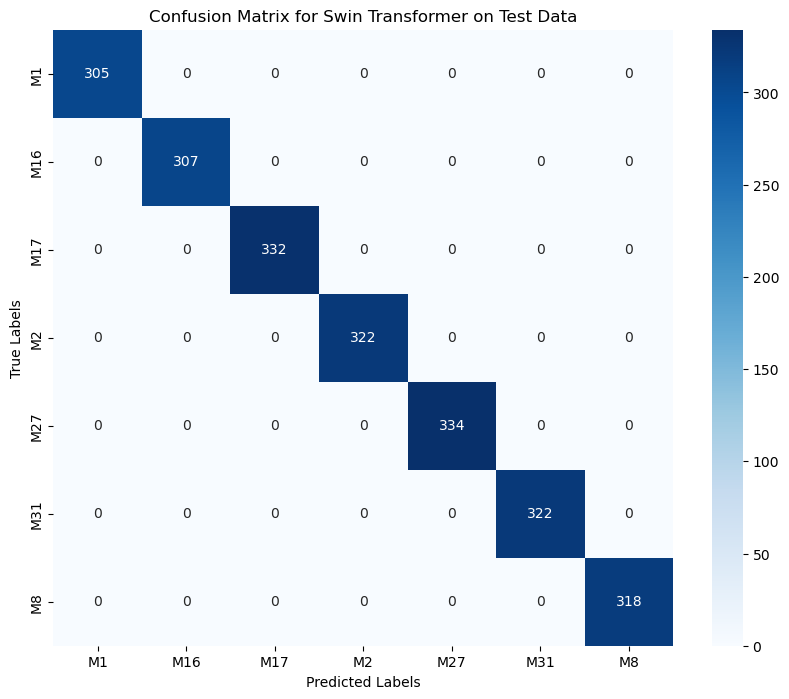

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use test_loader for unseen data
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Swin Transformer model
        outputs = model(images)
        
        # Extract logits
        logits = outputs.logits

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Swin Transformer on Test Data')
plt.show()

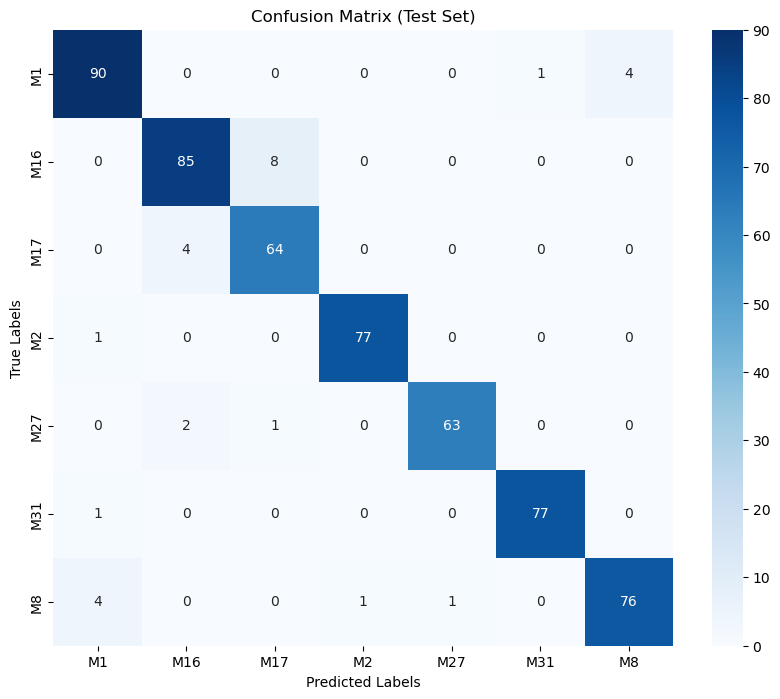

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in val_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Swin Transformer model
        outputs = model(images)  # Returns an object, not just logits
        
        # Extract logits from the model's output object
        logits = outputs.logits

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute the confusion matrix for test data
cm_test = confusion_matrix(all_labels_test, all_preds_test)

# Check if test_dataset has class names
class_names = val_dataset.classes if hasattr(val_dataset, 'classes') else [str(i) for i in range(len(cm_test))]

# Plot the confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',  xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Set)')
plt.show()



In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for training data
all_preds_train = []
all_labels_train = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Swin Transformer model
        outputs = model(images)  # This will return an object, not just logits
        
        # Extract logits (adjust depending on model output structure)
        logits = outputs.logits  

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

# Compute F1-score, precision, and recall for training set
f1_train = f1_score(all_labels_train, all_preds_train, average='weighted')  # Use 'macro' for equal class weighting
precision_train = precision_score(all_labels_train, all_preds_train, average='weighted')
recall_train = recall_score(all_labels_train, all_preds_train, average='weighted')

# Print the results
print(f"Training F1 Score: {f1_train:.4f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")

Training F1 Score: 1.0000
Training Precision: 1.0000
Training Recall: 1.0000


In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in val_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Swin Transformer model
        outputs = model(images)  # This returns an object, not just logits
        
        # Extract logits from the model's output object
        logits = outputs.logits  

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute F1-score, precision, and recall for the test set
f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')  # Change to 'macro' if needed
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')

# Print the results
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")

Test F1 Score: 0.9428
Test Precision: 0.9433
Test Recall: 0.9429


In [7]:
import torch.nn.functional as F
# Function to compute MCCS for the entire dataset
def compute_mccs(model, dataloader, device):
    model.eval()
    mccs_scores = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Computing MCCS"):
            images = images.to(device)
            
            # Forward pass
            outputs = model(images)
            logits = outputs.logits  # Extract logits

            # Compute softmax probabilities
            probabilities = F.softmax(logits, dim=1)

            # Compute MCCS (maximum probability of the predicted class)
            mccs = torch.max(probabilities, dim=1).values
            mccs_scores.extend(mccs.cpu().numpy())  # Store in a list

    return mccs_scores

# Compute MCCS scores
mccs_scores = compute_mccs(model, val_loader, device)

# Save MCCS scores to a CSV file
import pandas as pd
df_mccs = pd.DataFrame({"MCCS Score": mccs_scores})
df_mccs.to_csv("mccs_scores.csv", index=False)

print("MCCS computation complete! Scores saved to 'mccs_scores.csv'.")

Computing MCCS: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]

MCCS computation complete! Scores saved to 'mccs_scores.csv'.
